In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
from codes.docs.analysis import data_preprocessing, data_exploration, data_preprocessing_high_dimension, graph_analysis
from codes.docs.analysis.gene_analysis import genetic_steps

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

In [4]:
dataset = '../../dataset'
preprocessed_dataset = './preprocessed_dataset/'

## Diffusion

In [6]:
european_diffusion_dataset = pd.read_csv('./preprocessed_dataset/imaging_data/diffusion/term/european_diffusion_df.csv')
# mixed_diffusion_dataset = pd.read_csv('./preprocessed_dataset/imaging_data/diffusion/term/mixed_diffusion_df.csv')

In [7]:
cols = european_diffusion_dataset.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns.to_list()
prs_cols = [prs for prs in european_diffusion_dataset.columns if 'PRS' in prs]
european_diffusion_dataset['total_streamline_count'] = european_diffusion_dataset[cols].sum(axis=1)
european_diffusion_dataset = data_exploration.MassUnivariate.remove_outliers(european_diffusion_dataset,
                                               col='total_streamline_count',threshold=3)

In [8]:
european_diffusion_dataset.shape

(156, 4512)

In [10]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
df = european_diffusion_dataset.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
cols = european_diffusion_dataset.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns.to_list()

european_diffusion_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
                                                cat_independentVar_cols=['Gender'],
                                                cont_independentVar_cols=['GA_diff', 'PMA_diff']+ancestry,
                                                dependentVar_cols=cols,
                                                thresholds=thresholds)
# # ancestry = ['mixed_Anc_PC' + str(i) for i in range(1,6)]
# # df = mixed_diffusion_dataset.copy()
# # mixed_diffusion_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
# #                                                 cat_independentVar_cols=['Gender'],
# #                                                 cont_independentVar_cols=['GA_diff', 'PMA_diff']+ancestry,
# #                                                 dependentVar_cols=cols,
# #                                                 thresholds=thresholds)

100%|███████████████████████████████████████████| 11/11 [01:15<00:00,  6.84s/it]


In [13]:
cols = european_diffusion_dataset.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns.to_list()
combined = european_diffusion_dataset[cols].copy()
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 3942.3141986437827
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 232.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0002155172413793039


In [35]:
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(european_diffusion_dataset,
                                                              dependentVar_cols=cols,n_components=.80)

In [36]:
df = european_diffusion_dataset
european_diffusion_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_diff', 'PMA_diff']+ancestry,
    dependentVar_cols=X_pca)


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 11.01it/s]


In [38]:
pca.n_components_

39

In [42]:
 0.05/(232*7)

3.078817733990148e-05

In [37]:
european_diffusion_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
64,Dependent_Var_25,0.040530,0.714347,-0.147482,0.142203,0.019967,0.841792,-0.106101,0.188736,0.041509,0.597566,0.142220,0.075224,-0.268423,0.000944,-0.081060,0.606856,PRS_1e-07
404,Dependent_Var_14,0.070564,0.529382,0.019524,0.847176,0.110228,0.279647,-0.056072,0.491598,0.121218,0.132464,0.140026,0.082513,-0.244127,0.003339,-0.141129,0.377251,PRS_1
365,Dependent_Var_14,0.064866,0.562915,0.020916,0.836545,0.107605,0.291175,-0.055683,0.494932,0.115471,0.150774,0.141635,0.079469,-0.239833,0.003749,-0.129732,0.416088,PRS_0.5
308,Dependent_Var_35,-0.062962,0.578876,-0.010950,0.915197,0.044495,0.665769,-0.019497,0.811692,-0.030916,0.702427,0.049328,0.543698,-0.231489,0.005208,0.125923,0.435464,PRS_0.05
192,Dependent_Var_36,-0.039496,0.728472,0.279860,0.006216,-0.198914,0.050055,0.065402,0.418138,-0.033101,0.675981,-0.097060,0.230334,0.227142,0.007459,0.078992,0.632129,PRS_0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,Dependent_Var_15,-0.043671,0.702627,-0.157190,0.129675,0.053342,0.607454,0.120627,0.148003,0.006919,0.932646,0.106171,0.195790,-0.001952,0.981371,0.087342,0.591826,PRS_1
87,Dependent_Var_9,-0.021400,0.851767,-0.029973,0.773430,-0.037919,0.715073,0.022216,0.787637,-0.030347,0.709541,0.174075,0.035499,0.001863,0.981675,0.042800,0.792245,PRS_1e-06
368,Dependent_Var_17,-0.075365,0.514292,-0.169215,0.106810,0.088267,0.400455,0.009944,0.905778,-0.057516,0.486205,-0.060936,0.462120,-0.001880,0.982157,0.150731,0.359341,PRS_0.5
239,Dependent_Var_5,-0.152327,0.173033,-0.312111,0.002360,0.336577,0.001008,-0.007259,0.927874,-0.078425,0.322344,-0.028240,0.723838,-0.000856,0.991672,0.304653,0.057611,PRS_0.01


In [6]:
ROIs = pd.read_csv('preprocessed_dataset/imaging_data/diffusion/Regions_of_Interest.csv')
ROIs['new_abbr'] = [i.replace('\xa0','') for i in ROIs['new_abbr']]
original_nodes = data_preprocessing.Diffusion.create_nodes_from_ROIs_combinations(cols)
updated_nodes_names = ROIs.loc[:,'new_abbr']
group_node_list = defaultdict(list)
for group in updated_nodes_names.unique():
    group_node_list[group] = updated_nodes_names[updated_nodes_names==group].index.tolist()

In [7]:
df = european_diffusion_dataset[cols].to_numpy()
new_df_matrix = np.empty((df.shape[0],int(len(group_node_list)**2/2-len(group_node_list)/2)))
for row in range(df.shape[0]):
    temp_matrix = graph_analysis.Graph_analysis.reverse_lower_triangle(df[row,:])
    updated_matrix, updated_colname = graph_analysis.Graph_analysis.combine_nodes_together(temp_matrix,
                                                                         grouped_node_list = group_node_list,
                                                                         original_node_list = cols)
    new_df_matrix[row,:] = graph_analysis.Graph_analysis.lower_triangle(updated_matrix)

In [8]:
new_colnames = graph_analysis.Graph_analysis.lower_triangle(data_preprocessing.Diffusion.create_ROIs_combinations(ROIs = updated_colname.tolist()))

In [26]:
new_df = pd.DataFrame(new_df_matrix)
new_df.columns = new_colnames
new_df['GA_diff'] = df['GA_diff']
new_df['PMA_diff'] = df['PMA_diff']
new_df[ancestry] = df[ancestry]
new_df[thresholds] = df[thresholds]
new_df['Gender'] = df['Gender']

In [31]:
new_colnames

array(['PreCG.R_PreCG.L', 'SFG.L_PreCG.L', 'SFG.L_PreCG.R', ...,
       'ITG.R_MTG.L', 'ITG.R_MTG.R', 'ITG.R_ITG.L'], dtype='<U17')

In [33]:
new_df_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(new_df,
                                                cat_independentVar_cols=['Gender'],
                                                cont_independentVar_cols=['GA_diff', 'PMA_diff']+ancestry,
                                                dependentVar_cols=new_colnames.tolist(),
                                                thresholds=thresholds)

100%|███████████████████████████████████████████| 11/11 [00:36<00:00,  3.34s/it]


In [43]:
new_df_mass_univariate[new_df_mass_univariate['PRS_pval']<0.05].sort_values(by='PRS_pval').groupby('Connection').head(1).head(50)

,Connection,const_coef,const_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
987,PreCUN.L_SPG.R,0.077980,0.464555,0.018722,0.847080,-0.274318,5.005362e-03,0.123950,0.109465,-0.066504,0.380838,-0.074907,0.327110,0.300644,0.000121,-0.155959,0.303133,PRS_1e-08
7029,PreCUN.L_IOG.R,-0.003782,0.971507,-0.168734,0.081648,-0.110841,2.487263e-01,-0.161883,0.035782,-0.158868,0.036618,-0.000010,0.999898,0.275159,0.000379,0.007564,0.959847,PRS_1e-05
19453,PUT.R_IOG.L,-0.090505,0.399534,-0.026043,0.789892,-0.249699,1.100944e-02,-0.041649,0.602066,0.010291,0.892835,0.013340,0.863717,0.287437,0.000383,0.181011,0.235676,PRS_0.5
5504,THA.L_SPG.R,0.040524,0.700020,0.207826,0.031274,-0.435083,9.916065e-06,0.060399,0.427750,0.056702,0.449259,0.033565,0.655960,0.265321,0.000542,-0.081048,0.587141,PRS_1e-06
17394,PUT.L_SPG.R,0.079750,0.470986,0.011701,0.907502,-0.157767,1.166375e-01,0.108344,0.187497,-0.011302,0.885765,-0.134812,0.094293,0.284466,0.000633,-0.159500,0.310011,PRS_0.1
6884,SPG.R_CG.L,0.055649,0.616950,-0.112979,0.265568,0.016356,8.709905e-01,0.135402,0.093677,-0.000643,0.993528,-0.087119,0.275210,0.273738,0.000742,-0.111298,0.480982,PRS_1e-05
13592,THA.R_OLF.R,0.091125,0.375489,-0.097777,0.298335,0.469152,1.251268e-06,-0.039697,0.598420,0.078122,0.286185,0.078831,0.287042,-0.248947,0.001109,-0.182250,0.212286,PRS_0.01
17297,CAU.L_SPG.R,0.087783,0.422861,-0.014514,0.884233,-0.128132,1.973472e-01,0.159700,0.050494,-0.091763,0.239733,-0.201136,0.012175,0.266496,0.001194,-0.175566,0.259124,PRS_0.1
14340,PHG.R_HIP.L,-0.112972,0.307929,-0.152215,0.131952,0.055714,5.788743e-01,0.009752,0.904682,-0.082820,0.293724,-0.149340,0.064032,0.267249,0.001228,0.225944,0.151359,PRS_0.05
3050,PreCUN.R_PreCUN.L,0.102024,0.361094,0.020992,0.836344,-0.069887,4.892904e-01,0.064351,0.425952,0.051696,0.515163,-0.090069,0.260558,0.254655,0.001706,-0.204048,0.198695,PRS_1e-07


In [36]:
corr_matrix = np.corrcoef(new_df.loc[:,new_colnames.tolist()],rowvar=False)
data_exploration.matSpDLite(corr_matrix)

Effective Number of Independent Variables [Veff] is 1980.097397822293
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 232.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0002155172413793084


In [11]:
corr_matrix = np.corrcoef(european_diffusion_dataset.loc[:,european_diffusion_dataset.columns.isin(cols)],rowvar=False)
data_exploration.matSpDLite(corr_matrix)

Effective Number of Independent Variables [Veff] is 3942.3141986437827
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 232.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0002155172413793039


Perform Network based statistics

In [43]:
df = european_diffusion_dataset.copy()
cols = df.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns.to_list()
prs = [i for i in df.columns if 'PRS' in i]
ancestry_PCs = [f'euro_Anc_PC{i}' for i in range(1,4)]
# get adjusted values: for connections values = adjusted for GA_diff and PMA_diff
# for PRS: adjust for ancestry values
adjusted_connections = df[cols].to_numpy()
adjusted_prs = df[prs].to_numpy()

In [44]:
adjusted_connections = np.apply_along_axis(
    data_exploration.MassUnivariate.adjust_covariates_with_lin_reg,
    0,
    adjusted_connections,
    df[['GA_diff', 'PMA_diff']].to_numpy())

In [45]:
adjusted_prs = np.apply_along_axis(
    data_exploration.MassUnivariate.adjust_covariates_with_lin_reg,
    0,
    adjusted_prs,
    df[ancestry_PCs].to_numpy())

In [46]:
t_matrix = graph_analysis.NBS.calculate_t_matrix(X=adjusted_connections,y=adjusted_prs[:,4])

In [47]:
t_matrix = graph_analysis.Graph_analysis.reverse_lower_triangle(t_matrix)

In [51]:
all_t_perm = graph_analysis.NBS.get_permutation(X = adjusted_connections,
                                      y = adjusted_prs[:,4])

100%|███████████████████████████████████████| 1000/1000 [07:53<00:00,  2.11it/s]


In [64]:
t = 10
null_distribution = graph_analysis.NBS.get_null_distribution(all_t_perm,threshold = t)
p_vals, comps, ind_sz, sz_links = graph_analysis.NBS.get_p_val(X = adjusted_connections,
                            y = adjusted_prs[:,4],
                            null_distribution=null_distribution,
                            threshold = t)

In [69]:
file_name = f'./preprocessed_dataset/imaging_data/diffusion/term/NBS/european/all_t_perm_{prs_cols[4]}.txt'
np.savetxt(file_name,all_t_perm)

In [9]:
# df=np.asarray(european_diffusion_dataset[cols])
df = new_df_matrix.copy()
new_df_matrix = np.empty((df.shape[0],64))
for row in range(df.shape[0]):
    temp_matrix = df[row,:]
    temp_matrix = graph_analysis.Graph_analysis.reverse_lower_triangle(temp_matrix,64)
    temp_matrix = temp_matrix.sum(axis=1)
    new_df_matrix[row,:] = temp_matrix
    


In [13]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
thresholds = [i for i in df.columns if 'PRS' in i]
df = european_diffusion_dataset
new_df = pd.DataFrame(new_df_matrix)
new_df.columns = updated_colname
new_df['GA_diff'] = df['GA_diff']
new_df['PMA_diff'] = df['PMA_diff']
new_df[ancestry] = df[ancestry]
new_df[thresholds] = df[thresholds]
new_df['Gender'] = df['Gender']

In [15]:
new_df_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(new_df,
                                                cat_independentVar_cols=['Gender'],
                                                cont_independentVar_cols=['GA_diff', 'PMA_diff']+ancestry,
                                                dependentVar_cols=updated_colname.tolist(),
                                                thresholds=thresholds)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.85it/s]


In [50]:
adjusted_prs.shape[1]

11

In [73]:
prs

3

In [74]:
for prs in range(3,adjusted_prs.shape[1]):
    if prs == 4:
        continue
    file_name = f'./preprocessed_dataset/imaging_data/diffusion/term/NBS/european/all_t_perm_{prs_cols[prs]}.txt'
    all_t_perm = graph_analysis.NBS.get_permutation(X = adjusted_connections,
                                      y = adjusted_prs[:,prs])
    np.savetxt(file_name,all_t_perm)

100%|███████████████████████████████████████| 1000/1000 [07:43<00:00,  2.16it/s]


In [78]:
import glob
t = 1
all_files = glob.glob('./preprocessed_dataset/imaging_data/diffusion/term/NBS/european/*')
for file in all_files:
    prs_idx = [idx for idx, i in enumerate(prs_cols) if i in file][0]
    all_t_perm = np.loadtxt(file)
    null_distribution = graph_analysis.NBS.get_null_distribution(all_t_perm,threshold = t)
    p_vals, comps, ind_sz, sz_links = graph_analysis.NBS.get_p_val(X = adjusted_connections,
                                y = adjusted_prs[:,prs_idx],
                                null_distribution=null_distribution,
                                threshold = t)
    print(f'{prs_cols[prs_idx]}:{p_vals}')

PRS_0.1:[0.332]
PRS_0.05:[0.386]
PRS_0.001:[0.203]
PRS_1e-07:[0.54]
PRS_1e-08:[0.424]
PRS_0.5:[0.227]
PRS_0.0001:[0.324]
PRS_0.01:[0.241]
PRS_1e-06:[0.771]
PRS_1:[0.208]
PRS_1e-05:[0.604]


In [7]:
# try cca

In [9]:
snp_file = pd.read_table(
    f'{preprocessed_dataset}/genetic_data/all_PRS_European/output.perm.snp'
)

In [10]:
best_SNPs = genetic_steps.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=5e-8)

In [11]:
new_bed_file = genetic_steps.SNPsFunctionalAnalysis.extract_new_bed_file(bed_file='../../dataset/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed',
                                                                         snps_list=best_SNPs.SNP.tolist(),
                                                                         fid_list=european_diffusion_dataset.ID.tolist())

In [12]:
new_bed_file.genotype[np.isnan(new_bed_file.genotype)] = 0

In [61]:
pca_X = PCA()
X_pca = pca_X.fit_transform(new_bed_file.genotype)

In [62]:
Y = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
    european_diffusion_dataset[cols],
    european_diffusion_dataset[ancestry +
                               ['Gender', 'PMA_diff', 'GA_diff']]).to_numpy()

In [63]:
pca_Y = PCA()
Y_pca = pca_Y.fit_transform(Y)

In [64]:
Y_pca.shape

(156, 156)

In [51]:
from sklearn.cross_decomposition import CCA

In [52]:
from statsmodels.multivariate.cancorr import CanCorr

In [65]:
cca = CCA(5)
X_ccr, Y_ccr = cca.fit_transform(X_pca,Y_pca)

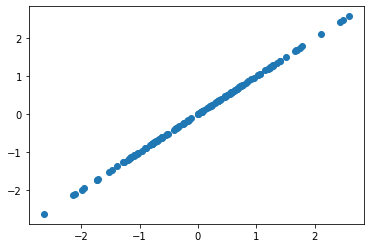

In [66]:
plt.plot(X_ccr[:,0],Y_ccr[:,0],'o')

In [67]:
np.corrcoef(X_ccr[:,0],Y_ccr[:,0])

array([[1., 1.],
       [1., 1.]])

In [78]:
stats_cca = CanCorr(X_pca[:,0:2],Y_pca[:,0:2])

In [79]:
stats_cca.corr_test().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Cancorr results
====================================================================
  Canonical Correlation Wilks' lambda Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------------
0                0.1240        0.9841 4.0000 304.0000  0.6129 0.6537
1                0.0238        0.9994 1.0000 153.0000  0.0869 0.7686
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
Multivariate Statistics and F Approximations                        
----------------------------------------------------------------------
                         Value    Num DF    Den DF    F Value   Pr > F
----------------------------------------------------------------------
Wilks' lambda            0.9841   4.0000   304.0000    0.6129   0.6537
Pillai's trace           0.0159   4.0000   306.0000    0.6148   0.6523
Hotelling-Lawley trace   0.0162   4.0000   181.3651    0.6137   0.6533
Roy's greatest root      0.0156   2.0000   153.0000    1.1947   0.3056
====================================================================

"""

In [16]:
np.apply_along_axis

<function numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)>

In [ ]:
X

In [30]:
new_bed_file.genotype = new_bed_file.read()

In [54]:
new_bed_file.genotype.shape

(291, 1599634)

In [38]:
import bed_reader

In [40]:
old_bed_file = bed_reader.open_bed(f'{dataset}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed')

In [42]:
old_bed_file.genotype = old_bed_file.read()

In [53]:
old_bed_file.genotype.shape

(291, 1599634)

In [51]:
(old_bed_file.genotype == new_bed_file.genotype).all(axis=0)

(1599634,)

In [55]:
snps_list=best_SNPs.SNP.tolist()
new_sid = [idx for idx, sid in enumerate(old_bed_file.sid) if sid in snps_list]

In [59]:
old_bed_file.genotype = old_bed_file.genotype[:,new_sid]

In [62]:
assertold_bed_file.genotype 

array([[1., 0., 0., ..., 0., 2., 0.],
       [1., 1., 0., ..., 0., 1., 1.],
       [2., 1., 1., ..., 0., 0., 2.],
       ...,
       [1., 2., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 1., 1.]], dtype=float32)

In [64]:
assert None is not None

AssertionError: 

In [8]:
best_SNPs_annot = genetic_steps.SNPsFunctionalAnalysis(snps_list=best_SNPs.SNP.to_list(),
                                                      bed_file=f'{dataset_path}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed')

NameError: name 'best_SNPs' is not defined

In [7]:
import bed_reader

In [21]:
genetic_data = bed_reader.open_bed(f'{dataset}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed')

In [27]:
genetic_data.sid.shape

(1599634,)

In [31]:
genetic_data.genotype = genetic_data.read()

In [35]:
from sklearn.decomposition import PCA


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [42]:
genetic_data.genotype[np.isnan(genetic_data.genotype)] = 0

In [ ]:
X_pca = PCA().fit_transform(genetic_data.genotype)

In [ ]:
X_pca

In [9]:
from sklearn.cross_decomposition import CCA

In [10]:
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [3.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]

In [15]:
cca = CCA().fit(X,Y)

In [17]:
X_c, Y_c = cca.transform(X,Y)

In [47]:
np.corrcoef(X_c[:,1],Y_c[:,0])

array([[ 1.00000000e+00, -4.86981369e-15],
       [-4.86981369e-15,  1.00000000e+00]])

In [9]:
remove_zero_features_euro = MLtraining.Retain_non_zero_features().fit(
    european_diffusion_dataset_term.loc[:, 'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
remove_zero_features_euro.get_column_names(
    european_diffusion_dataset_term.loc[:,
                                     'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns)

remove_zero_features_mixed = MLtraining.Retain_non_zero_features().fit(
    mixed_diffusion_dataset_term.loc[:, 'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
remove_zero_features_mixed.get_column_names(
    mixed_diffusion_dataset_term.loc[:,
                                     'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns)

Retain_non_zero_features()

In [41]:
def remove_correlated(X,axis=0):
    if axis == 0:
        unique_X, idx = np.unique([tuple(row) for row in X],axis=0,return_index = True)
        return unique_X[idx]
    elif axis == 1:
        unique_X, idx = np.unique([tuple(col) for col in X.T],axis=0,return_index=True)
        return unique_X[idx].T

In [47]:
test = np.array([[1,2,1],[0,0,0]])
remove_correlated(test,axis=0)

array([[1, 2, 1],
       [0, 0, 0]])

In [81]:
european_diffusion_term_mass_univariate.to_csv(
    './preprocessed_data/diffusion/term/european_diffusion_term_mass_univariate.csv',
    index=False)
mixed_diffusion_term_mass_univariate.to_csv(
    './preprocessed_data/diffusion/term/mixed_diffusion_term_mass_univariate.csv',
    index=False)

In [10]:
european_diffusion_term_mass_univariate = pd.read_csv(
    './preprocessed_data/diffusion/term/european_diffusion_term_mass_univariate.csv'
)
mixed_diffusion_term_mass_univariate = pd.read_csv(
    './preprocessed_data/diffusion/term/mixed_diffusion_term_mass_univariate.csv'
)

In [11]:
remove_zero_features_euro.reduced_features_names

Index(['PreCG.R_PreCG.L', 'SFGdor.L_PreCG.L', 'SFGdor.L_PreCG.R',
       'SFGdor.R_PreCG.L', 'SFGdor.R_PreCG.R', 'SFGdor.R_SFGdor.L',
       'ORBsup.L_PreCG.L', 'ORBsup.L_SFGdor.L', 'ORBsup.L_SFGdor.R',
       'ORBsup.R_PreCG.L',
       ...
       'ITG.R_PUT.R', 'ITG.R_PAL.L', 'ITG.R_PAL.R', 'ITG.R_THA.L',
       'ITG.R_THA.R', 'ITG.R_HES.R', 'ITG.R_STG.R', 'ITG.R_TPOsup.R',
       'ITG.R_MTG.R', 'ITG.R_TPOmid.R'],
      dtype='object', length=2513)

##### hypothesis 

hypothesis: regions implicated in GM studies with tissue loss are: temporal, occipital, and frontal cortex, in the posterior ACC, in the insula, notably regions within the motor, somastosensory, parietal cortex may show tissue gain.

In [26]:
import re
frontal_connections = ['SFGdor',
                              'ORBsup',
                              'MFG',
                              'ORBmid',
                              'IFGoperc',
                              'IFGtriang',
                              'ORBinf',
                              'SFGmed',
                              'ORBsumed']
temporal_connections = ['STG','TPOsup','MTG','TPOmid','ITG']

# getting the fronto-temporal connection names
frontal_connections_ = european_diffusion_dataset_term.columns[[
    bool(re.search('|'.join(frontal_connections), i))
    for i in european_diffusion_dataset_term.columns
]]
frontal_temporal_connections = frontal_connections_[[
    bool(re.search('|'.join(temporal_connections),i))
    for i in frontal_connections_
]]

In [91]:
european_diffusion_term_mass_univariate.Connection[0]

'PreCG.R_PreCG.L'

In [95]:
# check which of these is found in the european
# first step, I will check if any of the frontotemporal connections come up significant, and if they do, i can check the matSPD if any of them reaches the signficance.

front_temporal_connections_mass_univariate = european_diffusion_term_mass_univariate[
    [
        bool(re.search('|'.join(frontal_temporal_connections), i))
        for i in european_diffusion_term_mass_univariate.Connection
    ]].reset_index(drop=True).copy()

In [132]:
front_temporal_connections_mass_univariate.PRS_pval.min()

0.0124690083832315

It seems that the there is no front_temporal_connection that survive multiple correction. (the Veff = 42, p-val = 0.001) Try with PCA to see if there is a way to summarise them all together. Trying even with pca doesn't seem to reach any kind of significance.

In [106]:
reduced_european_dataset = european_diffusion_dataset_term[remove_zero_features_euro.reduced_features_names.to_list()]
front_temporal_connections_df_euro = reduced_european_dataset.loc[:,
    [
        bool(re.search('|'.join(frontal_temporal_connections),i))
        for i in reduced_european_dataset.columns
    ]
]

In [120]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
front_temporal_connection_df_euro_pca = pca.fit_transform(np.asarray(front_temporal_connections_df_euro))

In [130]:
european_diffusion_dataset_term[
    'front_temporal_pca'] = front_temporal_connection_df_euro_pca

calculate_mass_univariate(european_diffusion_dataset_term,
                         cont_indpendentVar_cols=['GA_diff','PMA_diff','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3'],
                         dependentVar_cols=['front_temporal_pca'])

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.00it/s]


,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
0,front_temporal_pca,0.070382,0.543014,-0.138936,0.394415,0.007065,0.946248,-0.168856,0.106265,-0.082867,0.318673,0.053967,0.509252,0.122724,0.137592,-0.026907,0.743728,PRS_1e-08
1,front_temporal_pca,0.070359,0.543131,-0.138891,0.394541,0.006965,0.946986,-0.168828,0.106321,-0.082917,0.318367,0.054029,0.508789,0.122169,0.139211,-0.027365,0.739434,PRS_1e-07
2,front_temporal_pca,0.069620,0.547332,-0.137432,0.399360,0.006073,0.953741,-0.168898,0.106228,-0.082062,0.322999,0.054002,0.509214,0.122074,0.139565,-0.021542,0.793116,PRS_1e-06
3,front_temporal_pca,0.069196,0.549846,-0.136595,0.402357,0.005500,0.958113,-0.168870,0.106350,-0.081269,0.327188,0.054017,0.509537,0.122310,0.138948,-0.015934,0.846349,PRS_1e-05
4,front_temporal_pca,0.069314,0.549216,-0.136828,0.401627,0.004720,0.964062,-0.168945,0.106276,-0.080717,0.331556,0.053716,0.512508,0.122211,0.139391,-0.008615,0.916972,PRS_0.0001
5,front_temporal_pca,0.069632,0.547194,-0.137455,0.399197,0.006346,0.951608,-0.168084,0.107995,-0.084101,0.313945,0.054310,0.506733,0.124096,0.134214,-0.028481,0.730540,PRS_0.001
6,front_temporal_pca,0.068589,0.553124,-0.135397,0.406247,0.009623,0.927005,-0.169261,0.105289,-0.087809,0.297896,0.054942,0.501764,0.125171,0.131035,-0.038875,0.643027,PRS_0.01
7,front_temporal_pca,0.069192,0.549871,-0.136586,0.402386,0.002084,0.984116,-0.170219,0.103981,-0.075961,0.369703,0.052382,0.521915,0.119702,0.151201,0.016637,0.843674,PRS_0.05
8,front_temporal_pca,0.069850,0.546168,-0.137885,0.398093,0.005175,0.960623,-0.168827,0.106523,-0.082686,0.331817,0.053470,0.513336,0.123678,0.138797,-0.012028,0.887252,PRS_0.1
9,front_temporal_pca,0.071245,0.537847,-0.140640,0.388426,0.009159,0.930287,-0.169434,0.104832,-0.091969,0.281794,0.055161,0.499857,0.128330,0.123858,-0.046828,0.580958,PRS_0.5


### Mass Univariate

### Mutiple comparison corrections

by Bonferroni we need 0.05/27643= 1e-6 to account for multiple testing correction

#### Computing the effective number of independent tests performed

Meff= Meff_connections * Meff_prs_thresholds

Multiple-comparison corrected p-value thresholds= 0.05/Meff

https://neurogenetics.qimrberghofer.edu.au/matSpDlite/

In [64]:
PRS_thresholds=[i for i in mixed_diffusion_dataset_term.columns if 'PRS' in i]
PRS_thresholds_corr_matrix=np.corrcoef(mixed_diffusion_dataset_term.loc[:,PRS_thresholds],rowvar=False)
np.savetxt('./preprocessed_data/diffusion/term/data_exploration/mixed_PRS_threshold_corr_matrix',PRS_thresholds_corr_matrix,delimiter='\t')

The Meff_prs_thresholds is 3

In [65]:
connectivity_corr_matrix=np.corrcoef(mixed_diffusion_dataset_term[remove_zero_features.reduced_features_names.to_list()],rowvar=False)
np.savetxt('./preprocessed_data/diffusion/term/data_exploration/mixed_connectivity_corr_matrix',connectivity_corr_matrix,delimiter='\t')

The Meff_connections is 1353.983

0.05/(1353.983*3)=1e-5, therefore, the p-value to reach is 1e-5

The lowest P-value we got is 2e-4, so none of our connections survived the multiple comparison correction in this case.

#### Permutation

Here we permute the PRS values, while keeping the order of the other values the same, and generate the p-value null distribution

In [101]:
# run codes/executable_code/perm_univariate_test

In [91]:
! mkdir log/diffusion/term/perm_univariate_test_csv/

In [101]:
import glob
import pickle

count=0
for file in tqdm.tqdm(glob.glob('./log/diffusion/term/perm_univariate_test/*')):
    with open(file,'rb') as fp:
        temp_model=pickle.load(fp)
    diffusion_term_p_val_temp=list()
    for (threshold,threshold_dict) in temp_model.items():
        diffusion_term_p_val_temp.append(pd.DataFrame(threshold_dict).T)

    diffusion_term_p_val_temp=pd.concat(diffusion_term_p_val_temp)
    diffusion_term_p_val_temp.reset_index(level=diffusion_term_p_val_temp.index.names, inplace=True)
    diffusion_term_p_val_temp.columns=['Connection','const_pval','GA.at.birth_pval','PMA.at.birth_pval','Gender_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval','PRS_threshold']
    diffusion_term_p_val_temp.to_csv(f'./log/diffusion/term/perm_univariate_test_csv/permuted_diffusion_term_p_val_{count}.csv',index=False)
    count+=1

100%|██████████| 1000/1000 [43:50<00:00,  2.63s/it]


(array([626., 199.,  97.,  33.,  18.,  10.,   9.,   5.,   2.,   1.]),
 array([9.71208302e-08, 1.07959372e-04, 2.15821624e-04, 3.23683875e-04,
        4.31546127e-04, 5.39408378e-04, 6.47270630e-04, 7.55132881e-04,
        8.62995132e-04, 9.70857384e-04, 1.07871964e-03]),
 <a list of 10 Patch objects>)

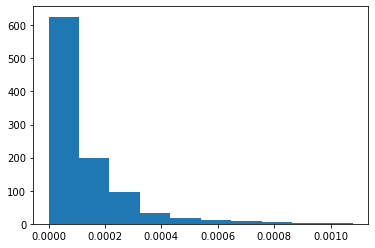

In [71]:
plt.hist(list(null_distribution))

#### Network based statistics:

Supra-threshold connections were considered if the p-value < 0.001



In [ ]:
### Choosing

The connectivity with significantly lower number of fibers in higher risk neonates identified by Shi et al., 2012 are 
- SOG.L_CAL.R (removed by preprocessing step)
- CUN.L_PCG.R (removed by preprocessing step)
- CAU.R_SOG.R 
- CAU.R_MOG.R
- PAL.R_PCL.R
- TPOmid.R_THA.R

Other identified in the adult neuroimaging (generally deals with white matter microstructure)
- Frontal lobe to Thalamus, cingulate gyrus
- Frontal lobe to Insula, hippocampus-amygdala, temporal and occipital lobes
- Dopaminergic pathways: Hippocampus, Amygdala, Caudate, Putamen, Pallidum, Thalmus


In [48]:
diffusion_term_p_val=pd.read_csv('./preprocessed_data/diffusion/term/obsv_diffusion_term_p_val.csv')

In [76]:
from statsmodels.stats.multitest import fdrcorrection
adjusted_p_val=fdrcorrection(diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R','CAU.R_MOG.R','PAL.R_PCL.R','TPOmid.R_THA.R'] else False)]['prs_pval'])[1]

In [9]:
prefrontal_lobes=['SFGdor','ORBsup','MFG','ORBmid','IFGoperc','IFGtriang','ORBinf','SFGmed','ORBsumed']
cingulum=['ACG','DCG','PCG']
subcortical=['HIP','PHG','AMYG','CAU','PUT','PAL','THA','INS']
temporal=['STG','TPOsup','MTG','TPOmid','ITG']
occipital=['REC','CUN','CAL','LING','SOG','MOG','IOG','FFG']

In [14]:
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [15]:
temp_connectivity_list_ROIs=[region for region in data_preprocessing.lower_triangle(ROIs_combinations) for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[0]]
connectivity_list_ROIs=[region for region in temp_connectivity_list_ROIs for i in prefrontal_lobes+cingulum+subcortical+temporal+occipital if i in str.split(region,'_')[1]]

In [49]:
diffusion_term_p_val_ROIs=diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in connectivity_list_ROIs else False)]

In [50]:
diffusion_term_p_val_ROIs.sort_values(by=['prs_pval'])

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
7755,SFGmed.L_ORBinf.L,0.003205,0.434531,0.001121,0.250367,0.531204,8.759586e-01,0.889344,0.000221,X1e.05
17673,IFGtriang.R_ORBmid.R,0.096103,0.604636,0.625025,0.065700,0.652591,6.503052e-01,0.756805,0.000358,X0.05
22699,IFGtriang.R_ORBmid.R,0.035440,0.582585,0.648389,0.087465,0.718289,6.182548e-01,0.738372,0.000443,X0.5
5242,SFGmed.L_ORBinf.L,0.003724,0.413543,0.001007,0.283569,0.525348,9.328486e-01,0.844145,0.000502,X1e.06
25212,IFGtriang.R_ORBmid.R,0.036301,0.555784,0.678984,0.084013,0.705402,6.381027e-01,0.742407,0.000553,X1
...,...,...,...,...,...,...,...,...,...,...
11763,PAL.L_PCG.L,0.457168,0.016622,0.001593,0.776215,0.000102,7.305693e-08,0.089252,0.999827,X0.0001
16543,CAU.L_CUNE.L,0.948979,0.336769,0.615906,0.088348,0.454481,8.330850e-01,0.017633,0.999836,X0.01
13099,PCG.R_INS.R,0.033960,0.516769,0.671330,0.148313,0.000630,1.432693e-02,0.523487,0.999850,X0.001
14319,PAL.R_ORBmid.R,0.000503,0.529732,0.000089,0.677981,0.658101,4.660996e-01,0.339856,0.999904,X0.001


In [74]:
def ipsilateral_or_not(connection,side=False):
    regions=str.split(connection,'_')
    if str.split(regions[0],'.')[1]==str.split(regions[1],'.')[1]:
        if side:
            return str.split(regions[0],'.')[1]
        else:
            return 1
    else:
        return 0

In [83]:
ipsilateral_list=list(map(ipsilateral_or_not,[i for i in diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['prs_pval']<0.05]['Connection']],np.repeat(True,len(diffusion_term_p_val_ROIs))))
print(len(list(filter(lambda x: x!=0,ipsilateral_list)))/len(ipsilateral_list))
print(len(list(filter(lambda x: x=='R',ipsilateral_list)))/len(list(filter(lambda x: x!=0,ipsilateral_list))))

0.7294964028776978
0.5838264299802761


In [148]:
connectivity_ROIs_corr_matrix=np.corrcoef(european_diffusion_dataset_term_removed_zeros[[x for x in european_diffusion_dataset_term_removed_zeros.columns if x in connectivity_list_ROIs]],rowvar=False)
np.savetxt('connectivity_ROIs_corr_matrix',connectivity_ROIs_corr_matrix,delimiter='\t')

In [160]:
f'The p-value to reach is {0.05/(790.60528*3)} using new Meff'

'The p-value to reach is 2.108089471229773e-05 using new Meff'

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

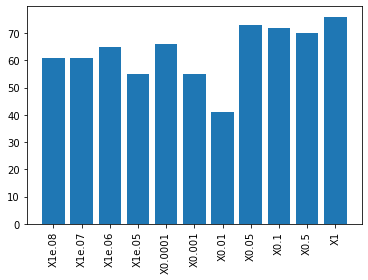

In [178]:
plt.bar(PRS_thresholds,[len(list(filter(lambda x: x<0.05,diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['PRS_threshold']==threshold].loc[:,'prs_pval']))) for threshold in PRS_thresholds])
plt.xticks(rotation='vertical')

In [ ]:
diffusion_term_p_val_ROIs[diffusion_term_p_val_ROIs['PRS_threshold'].filter()]

In [171]:
diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R','CAU.R_MOG.R','PAL.R_PCL.R','TPOmid.R_THA.R'] else False)]

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
1527,CAU.R_SOG.R,0.397299,0.191544,0.0730791,0.585685,0.90552,0.697604,0.214607,0.663863,X1e.08
1529,CAU.R_MOG.R,0.6207,0.693003,0.882247,0.150877,0.987798,0.246538,0.176945,0.302149,X1e.08
1803,PAL.R_PCL.R,0.855852,0.779127,0.470746,0.890325,0.817844,0.91293,0.279775,0.837431,X1e.08
2410,TPOmid.R_THA.R,0.73266,0.525345,0.716623,0.121095,0.679469,0.971265,0.718846,0.485892,X1e.08
4040,CAU.R_SOG.R,0.405493,0.180837,0.07115,0.580337,0.922287,0.691095,0.211536,0.791836,X1e.07
4042,CAU.R_MOG.R,0.628654,0.655978,0.905237,0.14822,0.964438,0.253996,0.1728,0.43837,X1e.07
4316,PAL.R_PCL.R,0.854435,0.786894,0.467055,0.888314,0.822958,0.915635,0.278316,0.880583,X1e.07
4923,TPOmid.R_THA.R,0.74185,0.534253,0.702298,0.121546,0.678735,0.965396,0.722754,0.511164,X1e.07
6553,CAU.R_SOG.R,0.383928,0.192692,0.0698015,0.587535,0.891105,0.699867,0.210942,0.521065,X1e.06
6555,CAU.R_MOG.R,0.633906,0.648789,0.913117,0.146265,0.957716,0.252376,0.16771,0.400263,X1e.06


Of these, only CAU.R_SOG.R showed consistent nominal significance across higher PRS thresholds

In [172]:
diffusion_term_p_val[diffusion_term_p_val['Connection'].map(lambda x: True if x in ['CAU.R_SOG.R'] else False)]

,Connection,const_pval,GA.at.birth_pval,PMA.at.birth_pval,Gender_pval,Anc_PC1_pval,Anc_PC2_pval,Anc_PC3_pval,prs_pval,PRS_threshold
1527,CAU.R_SOG.R,0.397299,0.191544,0.0730791,0.585685,0.90552,0.697604,0.214607,0.663863,X1e.08
4040,CAU.R_SOG.R,0.405493,0.180837,0.07115,0.580337,0.922287,0.691095,0.211536,0.791836,X1e.07
6553,CAU.R_SOG.R,0.383928,0.192692,0.0698015,0.587535,0.891105,0.699867,0.210942,0.521065,X1e.06
9066,CAU.R_SOG.R,0.392978,0.187259,0.0712153,0.57656,0.909467,0.702783,0.213027,0.627509,X1e.05
11579,CAU.R_SOG.R,0.344333,0.204858,0.070051,0.530469,0.865805,0.705173,0.232712,0.333378,X0.0001
14092,CAU.R_SOG.R,0.268645,0.230389,0.0740354,0.575032,0.786246,0.676486,0.262871,0.180954,X0.001
16605,CAU.R_SOG.R,0.173514,0.218737,0.0686738,0.599529,0.642998,0.766378,0.260197,0.112672,X0.01
19118,CAU.R_SOG.R,0.0846052,0.201968,0.0583407,0.617256,0.482436,0.744362,0.314669,0.0514321,X0.05
21631,CAU.R_SOG.R,0.0659298,0.196291,0.0562121,0.625832,0.457255,0.72375,0.338731,0.0410267,X0.1
24144,CAU.R_SOG.R,0.0405873,0.214395,0.0588269,0.680039,0.403141,0.773832,0.338588,0.0290905,X0.5


### Reducing the diffusion connectivity space with PCA

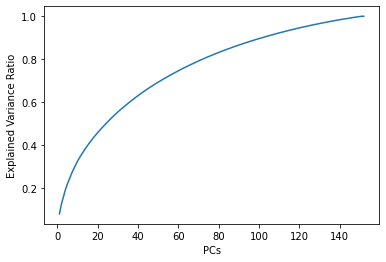

In [13]:
from sklearn.decomposition import PCA
diff_pca = StandardScaler().fit_transform(np.asarray(european_diffusion_dataset_term.loc[:,remove_zero_features.reduced_features_names]))
pca = PCA()
diff_pca = pca.fit_transform(diff_pca)

plt.plot(np.arange(1,diff_pca.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

european_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [15]:
#reducing the whole dataset

In [16]:
european_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [17]:
european_diffusion_term_pca_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in european_diffusion_dataset_term.columns if 'PRS' in i]):
    _, temp_model_summary = mass_univariate(european_diffusion_dataset_term, cat_independentVar_cols=['Gender'], cont_indpendentVar_cols=['GA_diff','PMA_diff','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=['PC0_diff'])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    european_diffusion_term_pca_univariate = european_diffusion_term_pca_univariate.append(temp_model_summary)

european_diffusion_term_pca_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:00<00:00, 50.58it/s]


In [18]:
european_diffusion_term_pca_univariate

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
0,PC0_diff,0.136202,0.103514,-0.268866,0.023153,0.067087,0.374690,-0.730207,1.380709e-17,-0.066710,0.265170,-0.011363,0.846874,-0.063865,0.282399,0.037358,0.528707,PRS_1e-08
1,PC0_diff,0.136462,0.103008,-0.269379,0.022951,0.068078,0.367699,-0.730147,1.424257e-17,-0.067496,0.259810,-0.011180,0.849389,-0.063033,0.288718,0.030724,0.604337,PRS_1e-07
2,PC0_diff,0.137283,0.100983,-0.271000,0.022129,0.068905,0.361729,-0.730091,1.453720e-17,-0.068278,0.254055,-0.011224,0.848898,-0.062938,0.289574,0.025809,0.662861,PRS_1e-06
3,PC0_diff,0.137807,0.099819,-0.272034,0.021691,0.069498,0.357817,-0.730143,1.476578e-17,-0.069144,0.247701,-0.011296,0.848121,-0.063240,0.287522,0.019946,0.736456,PRS_1e-05
4,PC0_diff,0.138608,0.097048,-0.273616,0.020641,0.065570,0.384451,-0.731349,1.167800e-17,-0.064664,0.279350,-0.014474,0.805937,-0.064485,0.277062,0.054587,0.358829,PRS_0.0001
5,PC0_diff,0.137187,0.100547,-0.270811,0.021961,0.066957,0.374010,-0.731765,1.162473e-17,-0.063081,0.293747,-0.012401,0.832945,-0.066707,0.262185,0.051941,0.383052,PRS_0.001
6,PC0_diff,0.138692,0.096903,-0.273782,0.020590,0.063528,0.401061,-0.729645,1.327004e-17,-0.059837,0.324022,-0.012719,0.828743,-0.067267,0.258481,0.054029,0.371064,PRS_0.01
7,PC0_diff,0.136473,0.102400,-0.269402,0.022692,0.066535,0.377430,-0.732863,1.123574e-17,-0.059591,0.327954,-0.012003,0.838220,-0.069676,0.244782,0.051246,0.398894,PRS_0.05
8,PC0_diff,0.135407,0.104425,-0.267297,0.023508,0.063465,0.399423,-0.731895,1.021329e-17,-0.053825,0.378575,-0.012665,0.829079,-0.072826,0.223950,0.069607,0.253973,PRS_0.1
9,PC0_diff,0.135071,0.105608,-0.266633,0.024000,0.064387,0.392912,-0.729414,1.279999e-17,-0.054543,0.374321,-0.012939,0.825642,-0.071403,0.232926,0.063222,0.300593,PRS_0.5


In [17]:
# the lowest p-value for PC0 was 0.0339 and there were other significant p-value at PC5 and 8.

In [18]:
from scipy.stats import pearsonr
pearsonr(european_diffusion_dataset_term.loc[:,'PMA_diff'],data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term.loc[:,'PRS_0.05']),np.asarray(european_diffusion_dataset_term.loc[:,['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']])))

(0.12446932481323456, 0.1265520385894824)

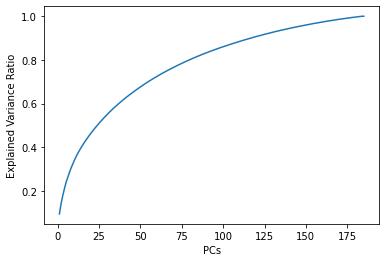

In [19]:
from sklearn.decomposition import PCA
diff_pca = StandardScaler().fit_transform(np.asarray(mixed_diffusion_dataset_term.loc[:,remove_zero_features.reduced_features_names]))
pca = PCA()
diff_pca = pca.fit_transform(diff_pca)

plt.plot(np.arange(1,diff_pca.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

mixed_diffusion_dataset_term['PC0_diff'] = diff_pca[:,0]

In [20]:
mixed_diffusion_term_pca_univariate = pd.DataFrame()
for threshold in tqdm.tqdm([i for i in mixed_diffusion_dataset_term.columns if 'PRS' in i]):
    _,temp_model_summary = mass_univariate(mixed_diffusion_dataset_term, cat_independentVar_cols=['Gender'], cont_indpendentVar_cols=['GA_diff','PMA_diff','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold],dependentVar_cols=['PC0_diff'])
    temp_model_summary.reset_index(drop = False,inplace=True)
    temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
    temp_model_summary['threshold'] = threshold
    
    mixed_diffusion_term_pca_univariate = mixed_diffusion_term_pca_univariate.append(temp_model_summary)

mixed_diffusion_term_pca_univariate.reset_index(drop = True, inplace= True)

100%|██████████| 11/11 [00:00<00:00, 54.20it/s]


In [21]:
mixed_diffusion_term_pca_univariate

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_diff_coef,GA_diff_pval,PMA_diff_coef,PMA_diff_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC2_pval,mixed_Anc_PC3_coef,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,threshold
0,PC0_diff,-0.105268,0.217676,0.214006,0.082992,-0.013896,0.863024,0.585587,6.450072e-12,0.047712,...,0.163053,-0.017903,0.810738,-0.071363,0.272921,-0.027013,0.672867,-0.009473,0.877010,PRS_1e-08
1,PC0_diff,-0.105164,0.218170,0.213794,0.083354,-0.013752,0.864388,0.585529,6.481325e-12,0.047426,...,0.162779,-0.017637,0.813650,-0.071333,0.273098,-0.027044,0.672403,-0.010767,0.860700,PRS_1e-07
2,PC0_diff,-0.105479,0.216670,0.214436,0.082256,-0.014380,0.858184,0.585638,6.456188e-12,0.048010,...,0.163247,-0.018090,0.808870,-0.071438,0.272497,-0.027257,0.669921,-0.006576,0.914510,PRS_1e-06
3,PC0_diff,-0.105537,0.216344,0.214554,0.082020,-0.016899,0.833601,0.586221,6.151377e-12,0.050518,...,0.164064,-0.020162,0.787840,-0.072347,0.266635,-0.027591,0.665960,0.013231,0.829592,PRS_1e-05
4,PC0_diff,-0.105602,0.216126,0.214686,0.081878,-0.014969,0.852374,0.585785,6.375391e-12,0.048472,...,0.162939,-0.018341,0.807139,-0.071579,0.271770,-0.027422,0.667969,-0.002232,0.971302,PRS_0.0001
5,PC0_diff,-0.105589,0.216220,0.214660,0.081966,-0.015257,0.849275,0.585847,6.306005e-12,0.048859,...,0.163106,-0.018683,0.803468,-0.071689,0.270542,-0.027462,0.667493,0.000158,0.997995,PRS_0.001
6,PC0_diff,-0.105770,0.215395,0.215027,0.081415,-0.013813,0.863792,0.585433,6.586783e-12,0.044800,...,0.168142,-0.016962,0.821701,-0.071889,0.269238,-0.027685,0.664958,-0.011333,0.865512,PRS_0.01
7,PC0_diff,-0.104098,0.222109,0.211627,0.085963,-0.011054,0.890306,0.586636,5.580249e-12,0.021959,...,0.180643,-0.010268,0.891586,-0.072755,0.262860,-0.030481,0.633627,-0.054327,0.458429,PRS_0.05
8,PC0_diff,-0.102366,0.228762,0.208107,0.090573,-0.006853,0.931778,0.585063,5.589780e-12,0.001880,...,0.194460,-0.003385,0.964175,-0.071306,0.271103,-0.032090,0.614836,-0.090940,0.228120,PRS_0.1
9,PC0_diff,-0.101240,0.233820,0.205817,0.094190,-0.005338,0.946858,0.582390,6.800252e-12,-0.010947,...,0.199382,-0.003188,0.966199,-0.069525,0.283137,-0.033578,0.598741,-0.102800,0.202525,PRS_0.5


### looking at the first PCs at the two extremes.

Correcting the first PC for the GA, PMA, Gender and Ancestry PCs

ttest showed significant differences in mean PCs between low and high risk groups (p=0.018) at 20%, but not at 25%, 30%, 


In [22]:

corrected_PC0 = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term['PC0_diff']),StandardScaler().fit_transform(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']]))

high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_diffusion_dataset_term['PRS_0.05']),StandardScaler().fit_transform(european_diffusion_dataset_term[['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']])),low_perc=.2,high_perc=.2)

In [23]:
corrected_PC0_df=pd.DataFrame({'PC0':corrected_PC0,'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(corrected_PC0))]}).dropna()

In [24]:
from scipy.stats import ttest_ind
ttest_ind(corrected_PC0_df[corrected_PC0_df['risk']=='low risk']['PC0'],corrected_PC0_df[corrected_PC0_df['risk']=='high risk']['PC0'],equal_var=True)

Ttest_indResult(statistic=-0.640315570567323, pvalue=0.5244053240975879)

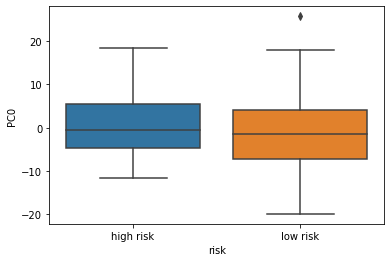

In [25]:
sns.boxplot(x='risk',y='PC0',data=corrected_PC0_df)

In [50]:
european_diffusion_dataset_term[['PC0_diff','GA_diff','PMA_diff','Gender','PRS_0.05','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']]

,PC0_diff,GA_diff,PMA_diff,Gender,PRS_0.05,euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3
0,-9.048619,39.000000,42.000000,1.0,-0.002568,0.039504,0.005096,0.011502
1,16.787308,39.714286,42.000000,1.0,-0.002409,-0.104926,0.017360,-0.081602
2,-12.470070,39.000000,42.857143,1.0,-0.002473,-0.131693,-0.071335,-0.005028
3,-15.841852,41.571429,42.857143,1.0,-0.002519,0.038875,0.025852,-0.040086
4,-21.370459,42.000000,43.285714,2.0,-0.002581,0.057020,-0.001994,-0.012540
...,...,...,...,...,...,...,...,...
147,-15.160833,41.285714,42.142857,2.0,-0.002459,0.022275,-0.027476,-0.007660
148,-10.043249,40.142857,43.714286,2.0,-0.002583,-0.058287,0.031794,0.008304
149,-11.878135,41.857143,42.000000,2.0,-0.002544,0.049823,-0.018725,0.004178
150,3.478842,37.714286,42.571429,2.0,-0.002514,0.039676,0.001762,0.035235


[0.5778532404624115, 0.9355937165306698, 0.8813055332692583, 0.19638160121434406]


[None]

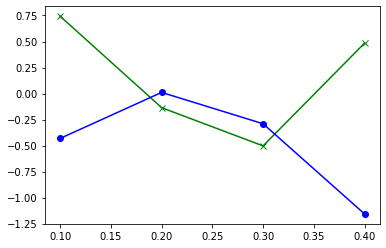

In [21]:
[draw_differences_across_percentages(mixed_diffusion_dataset_term,['PC0_diff'],['GA_diff','PMA_diff','Gender'],'PRS_1e-08',[0.1,0.2,0.3,0.4],['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3'])]

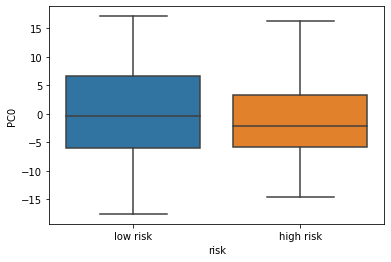

In [62]:

corrected_PC0 = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(mixed_diffusion_dataset_term['PC0_diff']),StandardScaler().fit_transform(mixed_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']]))

high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(mixed_diffusion_dataset_term['PRS_0.05']),StandardScaler().fit_transform(mixed_diffusion_dataset_term[['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5']])),low_perc=.3,high_perc=.3)

corrected_PC0_df=pd.DataFrame({'PC0':corrected_PC0,'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(corrected_PC0))]}).dropna()

from scipy.stats import ttest_ind
ttest_ind(corrected_PC0_df[corrected_PC0_df['risk']=='low risk']['PC0'],corrected_PC0_df[corrected_PC0_df['risk']=='high risk']['PC0'],equal_var=True)


sns.boxplot(x='risk',y='PC0',data=corrected_PC0_df)

## Microstructure

In [144]:
micro_labels = pd.read_excel(open('./dataset/microstructure/052021/dHCP-info-for-H_outcomes_and_rad_scores_05_2021.xlsx','rb'),sheet_name='wm_roi_notations')

In [60]:
micro_labels

,Label,Name
0,94,anterior_limb_of_internal_capsule_left
1,95,anterior_limb_of_internal_capsule_right
2,96,posterior_limb_of_internal_capsule_left
3,97,posterior_limb_of_internal_capsule_right
4,98,retrolenticular_part_of_internal_capsule_left
5,99,retrolenticular_part_of_internal_capsule_right
6,100,anterior_corona_radiata_left
7,101,anterior_corona_radiata_right
8,102,superior_corona_radiata_left
9,103,superior_corona_radiata_right


In [160]:
def get_micro_label(micro_labels,list_of_labels):
    label_number = []
    list_of_labels_copy = list_of_labels.copy()
    for idx,name in enumerate(micro_labels['Name']):
        for label in list_of_labels:
            if label in name:
                label_number.append(micro_labels.loc[idx,'Label'])
                try:
                    list_of_labels_copy.remove(label)
                except ValueError:
                    pass
    if len(list_of_labels_copy)!=0:
        print(list_of_labels_copy)
        raise Exception('this is not in the labels')
    return label_number


In [161]:
projection_fibers_labels = get_micro_label(
    micro_labels, ['cerebral_peduncle', 'internal_capsule', 'corona_radiata'])
association_fibers_labels = get_micro_label(micro_labels, [
    'cingulum', 'stria_terminalis', 'superior_longitudinal_fasc',
    'external_capsule', 'posterior_thalamic_radiation', 'sagittal_stratum',
    'fronto-occipital', 'uncinate_fasc'
])

corpus_callosum_labels = get_micro_label(micro_labels, ['cc_'])
limbic_fibers_labels = get_micro_label(
    micro_labels, ['cingulum', 'stria_terminalis'])
brainstem_fibers_labels = get_micro_label(
    micro_labels,
    ['corticospinal', 'medial_lemniscus', 'pontine', 'cerebellar_peduncle'])

In [162]:
def get_micro_values(df, micros=['FA', 'MD', 'FISO', 'T2']):
    new_df = df.copy()
    pipe0 = Pipeline([('scaler', StandardScaler()),
                      ('pca', PCA(n_components=1))])

    def get_pca_sum_mean(new_df, micro, fiber_name, fibers_labels):

        new_df[fiber_name + '_PCA_' + micro] = pipe0.fit_transform(
            new_df.loc[:, ['l' + str(i) + '_' + micro
                           for i in fibers_labels]].values)
        new_df[fiber_name + '_sum_' + micro] = new_df.loc[:, [
            'l' + str(i) + '_' + micro for i in fibers_labels
        ]].sum(axis=1)
        new_df[fiber_name + '_mean_' + micro] = new_df.loc[:, [
            'l' + str(i) + '_' + micro for i in fibers_labels
        ]].mean(axis=1)

    for micro in tqdm.tqdm(micros):

        get_pca_sum_mean(new_df,
                         micro,
                         fiber_name='Assoc',
                         fibers_labels=association_fibers_labels)
        get_pca_sum_mean(new_df,
                         micro,
                         fiber_name='Proj',
                         fibers_labels=projection_fibers_labels)
        get_pca_sum_mean(new_df,
                         micro,
                         fiber_name='Limbic',
                         fibers_labels=limbic_fibers_labels)
        get_pca_sum_mean(new_df,
                         micro,
                         fiber_name='CC',
                         fibers_labels=corpus_callosum_labels)
        get_pca_sum_mean(new_df,
                         micro,
                         fiber_name='Brainstems',
                         fibers_labels=brainstem_fibers_labels)

        new_df['PC0_' + micro] = pipe0.fit_transform(
            new_df[[i for i in new_df.columns if micro in i]].values)
        new_df['sum_' + micro] = new_df[[
            i for i in new_df.columns if micro in i
        ]].sum(axis=1)
        new_df['mean_' + micro] = new_df[[
            i for i in new_df.columns if micro in i
        ]].mean(axis=1)

    return new_df

In [163]:
european_microstructure_dataset_term = get_micro_values(european_microstructure_dataset_term)

mixed_microstructure_dataset_term = get_micro_values(mixed_microstructure_dataset_term)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.00it/s]


In [32]:
european_microstructure_term_mass_univariate = pd.DataFrame()
for micro in tqdm.tqdm(['FA']):
    for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS' in i]:
        dependentVariables = [i for i in european_microstructure_dataset_term.columns if micro in i]
        
        independentVariables = ['Gender','GA_micro', 'PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold]
        df = european_microstructure_dataset_term[dependentVariables+independentVariables].dropna()

        _,temp_model_summary = mass_univariate(df,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_micro','PMA_micro','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3',threshold],dependentVar_cols=dependentVariables,additional_info=micro)
        temp_model_summary.reset_index(drop = False,inplace=True)
        temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
        temp_model_summary['threshold'] = threshold
        european_microstructure_term_mass_univariate = european_microstructure_term_mass_univariate.append(temp_model_summary)

european_microstructure_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


In [58]:
set(european_microstructure_term_mass_univariate[european_microstructure_term_mass_univariate['PRS_pval']<0.05].Connection)

{'l107_FA', 'l110_FA', 'l111_FA', 'l125_FA', 'l134_FA', 'l135_FA'}

In [85]:
p = 0.0007
fa = 'l135_FA'
european_microstructure_term_mass_univariate[(european_microstructure_term_mass_univariate['Connection'] ==fa)
                                            & (european_microstructure_term_mass_univariate['PRS_pval']<p)].threshold.values

array([], dtype=object)

In [86]:
mixed_microstructure_term_mass_univariate[(mixed_microstructure_term_mass_univariate['Connection'] ==fa)
                                            & (mixed_microstructure_term_mass_univariate['PRS_pval']<p)].threshold.values

array([], dtype=object)

In [57]:
european_microstructure_term_mass_univariate[(european_microstructure_term_mass_univariate['Connection'] =='l111_FA')]

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
17,l111_FA,0.025754,0.808155,-0.051177,0.732987,-0.046641,0.631858,0.361014,0.000250,0.147534,0.050921,-0.052986,0.478657,-0.088275,0.240966,0.203338,0.007747,FA,PRS_1e-08
89,l111_FA,0.025627,0.808621,-0.050925,0.733618,-0.044110,0.649247,0.358154,0.000270,0.147847,0.049833,-0.054843,0.462360,-0.083175,0.268126,0.212930,0.005216,FA,PRS_1e-07
161,l111_FA,0.031521,0.765586,-0.062637,0.675428,-0.045890,0.635778,0.360428,0.000243,0.146247,0.051828,-0.056225,0.450607,-0.083767,0.264063,0.218197,0.004185,FA,PRS_1e-06
233,l111_FA,0.037919,0.718787,-0.075351,0.613359,-0.049976,0.604565,0.362016,0.000214,0.145458,0.051833,-0.057985,0.434494,-0.088393,0.236364,0.235587,0.001962,FA,PRS_1e-05
305,l111_FA,0.038414,0.714126,-0.076335,0.607200,-0.054589,0.570420,0.363635,0.000190,0.150996,0.043082,-0.063888,0.387732,-0.092146,0.215294,0.250342,0.001016,FA,PRS_0.0001
377,l111_FA,0.031085,0.769708,-0.061771,0.680991,-0.035599,0.713810,0.356031,0.000304,0.153663,0.042923,-0.060484,0.419452,-0.095775,0.203971,0.201584,0.008405,FA,PRS_0.001
449,l111_FA,0.036100,0.731983,-0.071737,0.630719,-0.046627,0.629079,0.359580,0.000239,0.168008,0.026900,-0.062972,0.397060,-0.101436,0.175654,0.234084,0.002372,FA,PRS_0.01
521,l111_FA,0.026837,0.796942,-0.053330,0.717704,-0.036853,0.699145,0.340219,0.000448,0.176175,0.019495,-0.067605,0.359121,-0.112223,0.131646,0.266660,0.000529,FA,PRS_0.05
593,l111_FA,0.023784,0.818478,-0.047262,0.747070,-0.036353,0.701186,0.344810,0.000344,0.188490,0.012547,-0.064901,0.375259,-0.120166,0.105241,0.286726,0.000197,FA,PRS_0.1
665,l111_FA,0.017070,0.869011,-0.033921,0.816732,-0.035688,0.706034,0.351367,0.000261,0.191368,0.011323,-0.068688,0.347883,-0.121945,0.100030,0.290357,0.000164,FA,PRS_0.5


In [167]:
np.round(mixed_microstructure_term_mass_univariate[(mixed_microstructure_term_mass_univariate['Connection'] =='l111_FA')][['PRS_coef','PRS_pval']],4)

,PRS_coef,PRS_pval
17,0.1870,0.0148
89,0.2004,0.0088
161,0.2057,0.0072
233,0.2224,0.0037
305,0.2359,0.0021
377,0.1861,0.0153
449,0.2151,0.0057
521,0.2483,0.0014
593,0.2674,0.0006
665,0.2751,0.0004


In [148]:
mixed_microstructure_dataset_term[[i for i in mixed_microstructure_dataset_term.columns if 'PRS' in i]]

,PRS_1e-08,PRS_1e-07,PRS_1e-06,PRS_1e-05,PRS_0.0001,PRS_0.001,PRS_0.01,PRS_0.05,PRS_0.1,PRS_0.5,PRS_1
0,0.006968,0.005306,0.003931,0.001672,-0.000351,-0.002478,-0.002987,-0.002568,-0.002262,-0.001416,-0.001101
1,0.017027,0.012317,0.008498,0.004195,0.001340,-0.001628,-0.002586,-0.002402,-0.002156,-0.001371,-0.001065
2,0.017552,0.012735,0.008544,0.004742,0.001412,-0.001539,-0.002621,-0.002409,-0.002141,-0.001363,-0.001061
3,0.015166,0.010467,0.006530,0.002886,0.000608,-0.001903,-0.002791,-0.002473,-0.002175,-0.001380,-0.001071
4,0.014084,0.010069,0.006861,0.003156,0.000344,-0.002001,-0.002901,-0.002519,-0.002237,-0.001403,-0.001090
...,...,...,...,...,...,...,...,...,...,...,...
184,0.006579,0.004561,0.002971,0.001120,-0.000353,-0.002389,-0.003058,-0.002583,-0.002292,-0.001436,-0.001117
185,0.014099,0.010648,0.007091,0.003836,0.001112,-0.001361,-0.002414,-0.002241,-0.002013,-0.001286,-0.001001
186,0.013932,0.010166,0.006674,0.003809,0.000866,-0.001743,-0.002697,-0.002352,-0.002078,-0.001337,-0.001040
187,0.016333,0.011323,0.007638,0.003807,0.000815,-0.001903,-0.002893,-0.002544,-0.002243,-0.001405,-0.001091


In [ ]:
mixed_volumetric_dataset_term[]

In [153]:
for threshold in [i for i in mixed_microstructure_dataset_term.columns if 'PRS' in i]:
    print(threshold,np.round(calculate_R_squared_explained(mixed_microstructure_dataset_term,
                                  dependentVar_col=['l111_FA'],
                                  cat_cols=['Gender'],
                                  cont_cols=[
                                      'GA_micro', 'PMA_micro', 'mixed_Anc_PC1',
                                      'mixed_Anc_PC2', 'mixed_Anc_PC3',
                                      'mixed_Anc_PC4', 'mixed_Anc_PC5',threshold
                                  ],
                                 col_to_drop=[threshold]),4))

PRS_1e-08 0.0445
PRS_1e-07 0.0483
PRS_1e-06 0.0538
PRS_1e-05 0.0596
PRS_0.0001 0.0642
PRS_0.001 0.0481
PRS_0.01 0.0618
PRS_0.05 0.0687
PRS_0.1 0.0722
PRS_0.5 0.0747
PRS_1 0.0772


In [145]:
?calculate_R_squared_explained

In [41]:
european_microstructure_term_mass_univariate[
    (european_microstructure_term_mass_univariate['Additional_info'] == 'FA')
    & (european_microstructure_term_mass_univariate['PRS_pval'] < 0.05
       )].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
737,l111_FA,0.015327,0.882180,-0.030458,0.835024,-0.035430,0.707802,0.349651,2.760500e-04,0.191217,0.011274,-0.067626,0.354822,-0.122321,0.098711,0.292794,0.000143,FA,PRS_1
665,l111_FA,0.017070,0.869011,-0.033921,0.816732,-0.035688,0.706034,0.351367,2.610954e-04,0.191368,0.011323,-0.068688,0.347883,-0.121945,0.100030,0.290357,0.000164,FA,PRS_0.5
593,l111_FA,0.023784,0.818478,-0.047262,0.747070,-0.036353,0.701186,0.344810,3.437031e-04,0.188490,0.012547,-0.064901,0.375259,-0.120166,0.105241,0.286726,0.000197,FA,PRS_0.1
521,l111_FA,0.026837,0.796942,-0.053330,0.717704,-0.036853,0.699145,0.340219,4.477690e-04,0.176175,0.019495,-0.067605,0.359121,-0.112223,0.131646,0.266660,0.000529,FA,PRS_0.05
305,l111_FA,0.038414,0.714126,-0.076335,0.607200,-0.054589,0.570420,0.363635,1.901454e-04,0.150996,0.043082,-0.063888,0.387732,-0.092146,0.215294,0.250342,0.001016,FA,PRS_0.0001
233,l111_FA,0.037919,0.718787,-0.075351,0.613359,-0.049976,0.604565,0.362016,2.144015e-04,0.145458,0.051833,-0.057985,0.434494,-0.088393,0.236364,0.235587,0.001962,FA,PRS_1e-05
449,l111_FA,0.036100,0.731983,-0.071737,0.630719,-0.046627,0.629079,0.359580,2.391765e-04,0.168008,0.026900,-0.062972,0.397060,-0.101436,0.175654,0.234084,0.002372,FA,PRS_0.01
161,l111_FA,0.031521,0.765586,-0.062637,0.675428,-0.045890,0.635778,0.360428,2.430844e-04,0.146247,0.051828,-0.056225,0.450607,-0.083767,0.264063,0.218197,0.004185,FA,PRS_1e-06
89,l111_FA,0.025627,0.808621,-0.050925,0.733618,-0.044110,0.649247,0.358154,2.699601e-04,0.147847,0.049833,-0.054843,0.462360,-0.083175,0.268126,0.212930,0.005216,FA,PRS_1e-07
589,l107_FA,-0.091778,0.380574,0.182380,0.218434,0.202309,0.035600,0.201839,3.507680e-02,-0.013604,0.856759,-0.036460,0.621141,-0.055548,0.456297,0.211526,0.005921,FA,PRS_0.1


In [18]:
european_microstructure_term_mass_univariate.loc[[
    idx for idx, i in enumerate(
        european_microstructure_term_mass_univariate['Connection'])
    if 'Limb' in i
], :].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
614,Limbic_mean_FA,-0.012374,0.898926,0.024589,0.858330,0.010603,0.905218,0.504682,6.125001e-08,0.061605,0.381020,-0.015584,0.820621,-0.095212,0.171602,0.174272,0.014693,FA,PRS_0.1
613,Limbic_sum_FA,-0.012374,0.898926,0.024589,0.858330,0.010603,0.905218,0.504682,6.125001e-08,0.061605,0.381020,-0.015584,0.820621,-0.095212,0.171602,0.174272,0.014693,FA,PRS_0.1
612,Limbic_PCA_FA,-0.015142,0.877640,0.030090,0.828705,0.029695,0.741192,0.479653,2.969438e-07,0.049824,0.482596,-0.017679,0.798885,-0.094728,0.177855,0.173603,0.016034,FA,PRS_0.1
545,Limbic_mean_FA,-0.010323,0.915676,0.020514,0.881725,0.009786,0.912564,0.501278,7.676838e-08,0.055616,0.426427,-0.017727,0.796750,-0.091125,0.189948,0.170572,0.016523,FA,PRS_0.05
544,Limbic_sum_FA,-0.010323,0.915676,0.020514,0.881725,0.009786,0.912564,0.501278,7.676838e-08,0.055616,0.426427,-0.017727,0.796750,-0.091125,0.189948,0.170572,0.016523,FA,PRS_0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,Limbic_sum_FISO,-0.068632,0.498843,0.136385,0.342828,-0.385160,0.000056,0.615573,4.120779e-10,0.032321,0.652226,-0.116868,0.103465,0.037657,0.599798,0.008631,0.905014,FISO,PRS_0.0001
1716,Limbic_PCA_FISO,-0.059221,0.577608,0.117682,0.434351,-0.291131,0.003228,0.485657,1.343381e-06,0.011534,0.878003,-0.156762,0.037670,0.067816,0.368183,-0.007912,0.916579,FISO,PRS_1e-06
1785,Limbic_PCA_FISO,-0.058333,0.583599,0.115918,0.441920,-0.292884,0.003071,0.485764,1.337912e-06,0.012620,0.866536,-0.157094,0.037300,0.068021,0.366608,0.006799,0.928361,FISO,PRS_1e-05
1578,Limbic_PCA_FISO,-0.058731,0.580593,0.116708,0.437750,-0.292547,0.003112,0.485721,1.340587e-06,0.012509,0.867919,-0.156940,0.037427,0.068018,0.366639,0.003975,0.958050,FISO,PRS_1e-08


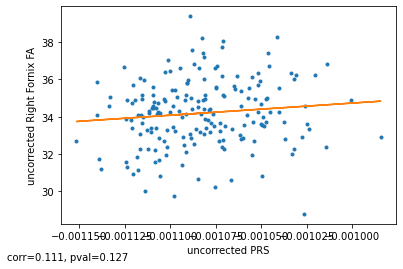

In [20]:
visualisation.plot_correlation(mixed_microstructure_dataset_term['PRS_1'],mixed_microstructure_dataset_term['Limbic_mean_FA'],xlabel='uncorrected PRS',ylabel='uncorrected Right Fornix FA')

In [49]:
european_microstructure_term_mass_univariate.loc[[idx for idx,i in enumerate(european_microstructure_term_mass_univariate['Connection']) if 'PC0_' in i],:].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Gender_2.0_coef,Gender_2.0_pval,GA_micro_coef,GA_micro_pval,PMA_micro_coef,PMA_micro_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Additional_info,threshold
343,PC0_FA,0.109752,0.149720,-0.218097,0.043890,0.088526,0.204821,-0.791198,3.048580e-22,-0.009095,0.865451,-0.005885,0.912405,0.013085,0.807545,-0.082547,0.128932,FA,PRS_0.0001
274,PC0_FA,0.109722,0.150013,-0.218037,0.044056,0.087333,0.210716,-0.790693,3.261320e-22,-0.007452,0.889471,-0.007763,0.884571,0.011841,0.825577,-0.080330,0.138356,FA,PRS_1e-05
3352,PC0_T2,-0.029835,0.777626,0.059287,0.691796,-0.120153,0.215322,-0.289558,2.928388e-03,-0.046475,0.538234,-0.091553,0.219909,0.146420,0.051914,-0.112752,0.139325,T2,PRS_0.01
3214,PC0_T2,-0.030258,0.774618,0.060129,0.687780,-0.117638,0.225909,-0.291349,2.768179e-03,-0.037431,0.616469,-0.091580,0.219841,0.141821,0.059314,-0.110809,0.142946,T2,PRS_0.0001
3145,PC0_T2,-0.030272,0.774623,0.060155,0.687810,-0.119285,0.219277,-0.290666,2.839737e-03,-0.035199,0.637270,-0.094111,0.207227,0.140153,0.062413,-0.107463,0.154191,T2,PRS_1e-05
550,PC0_FA,0.113815,0.135326,-0.226171,0.036538,0.082032,0.238322,-0.784251,6.815461e-22,-0.015512,0.775543,-0.005290,0.921372,0.018771,0.728090,-0.077216,0.160739,FA,PRS_0.05
205,PC0_FA,0.111848,0.142381,-0.222262,0.040055,0.086070,0.217455,-0.790156,3.624802e-22,-0.007809,0.884386,-0.008340,0.876139,0.010236,0.849073,-0.075528,0.163216,FA,PRS_1e-06
136,PC0_FA,0.113897,0.135226,-0.226333,0.036489,0.085412,0.220974,-0.789371,3.992396e-22,-0.008329,0.876882,-0.008824,0.869055,0.010042,0.851975,-0.073326,0.175842,FA,PRS_1e-07
481,PC0_FA,0.110792,0.146598,-0.220164,0.042265,0.085435,0.221022,-0.789859,3.879357e-22,-0.014006,0.796582,-0.006386,0.905151,0.015923,0.767627,-0.072969,0.183588,FA,PRS_0.01
3490,PC0_T2,-0.023512,0.823941,0.046722,0.754557,-0.127087,0.189549,-0.284313,3.543480e-03,-0.048788,0.522196,-0.092280,0.216942,0.151466,0.045756,-0.101568,0.186706,T2,PRS_0.1


In [164]:
mixed_microstructure_term_mass_univariate = pd.DataFrame()
for micro in tqdm.tqdm(['FA']):
    for threshold in [i for i in mixed_microstructure_dataset_term.columns if 'PRS' in i]:
        dependentVariables = [i for i in mixed_microstructure_dataset_term.columns if micro in i]
#         dependentVariables = ['l'+str(i)+'_FA' for i in projection_fibers_labels]
        
        independentVariables = ['Gender','GA_micro', 'PMA_micro','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold]
        df = european_microstructure_dataset_term[dependentVariables+independentVariables].dropna()

        _,temp_model_summary = mass_univariate(df,cat_independentVar_cols=['Gender'],cont_indpendentVar_cols=['GA_micro','PMA_micro','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5',threshold],dependentVar_cols=dependentVariables,additional_info=micro)
        temp_model_summary.reset_index(drop = False,inplace=True)
        temp_model_summary.rename({'index':'Connection',threshold+'_coef':'PRS_coef',threshold+'_pval':'PRS_pval'},axis = 1, inplace = True)
        temp_model_summary['threshold'] = threshold
        mixed_microstructure_term_mass_univariate = mixed_microstructure_term_mass_univariate.append(temp_model_summary)

mixed_microstructure_term_mass_univariate.reset_index(drop = True, inplace= True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


In [158]:
mixed_microstructure_term_mass_univariate[(mixed_microstructure_term_mass_univariate['Additional_info']=='FA') &(mixed_microstructure_term_mass_univariate['threshold']=='PRS_0.01')].sort_values(by='PRS_pval').to_csv('./preprocessed_data/microstructure/term/mixed_micro_Proj.csv',index=False)

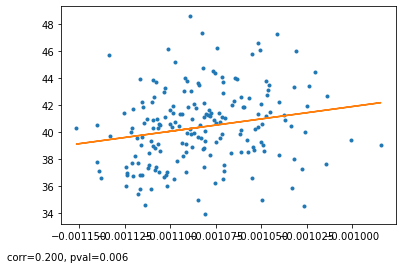

In [133]:
visualisation.plot_correlation(mixed_microstructure_dataset_term['PRS_1'],mixed_microstructure_dataset_term['l111_FA'])

[0.28853276000558375, 0.7705282116245872, 0.7005415150601515, 0.5626155274116088]


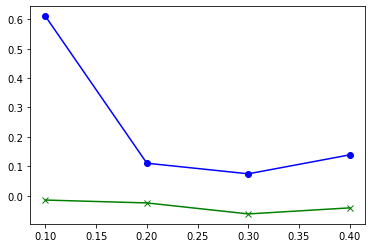

In [126]:
draw_differences_across_percentages(europ,dependentVar=['PMA_micro'],independentVar=['Gender'],threshold='PRS_1',percentages=[0.1,0.2,0.3,0.4],ancestry_PCs = ['euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3'])

In [ ]:
visualisation.plot_correlation()

In [60]:
european_microstructure_dataset_term['FA_sum'] = european_microstructure_dataset_term[[i for i in european_microstructure_dataset_term.columns if 'FA' in i]].mean(axis=1)

[0.26028568541685654, 0.1990754228755321, 0.14826448709126114, 0.20811916738819855]
[0.07624124368489356, 0.193150279062215, 0.04344090876830027, 0.034813652441864094]
[0.021924003950949445, 0.08544757184034778, 0.20229540913580016, 0.15281496772340272]
[0.013968110893568893, 0.1807494151168394, 0.12747992085036208, 0.10569435800622629]
[0.015367124953012953, 0.04927578617808847, 0.1964847428681526, 0.162738506467807]
[0.017471791379291998, 0.024371638473562187, 0.0688518358011197, 0.2882098750289226]
[0.005181092804263292, 0.08024568920259603, 0.08372037675761926, 0.041123598616995084]
[0.19584518720395186, 0.022384949850359097, 0.12787252658267365, 0.024724087675684674]
[0.042982147177036585, 0.11115083090582892, 0.1952209203084952, 0.1591139611814614]
[0.3347289801825648, 0.22480838673835735, 0.10875882217633437, 0.09848168535462426]
[0.3667071201913784, 0.23747483892054055, 0.19498833629495024, 0.13460763656404748]


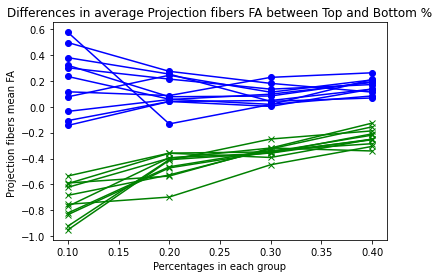

In [60]:
for threshold in [i for i in european_microstructure_dataset_term.columns if 'PRS' in i]:
    draw_differences_across_percentages(mixed_microstructure_dataset_term,dependentVar=['Proj_mean_FA'],independentVar=['GA_micro','PMA_micro','Gender'],threshold = threshold,percentages = [0.1,0.2,0.3,0.4],ancestry_PCs = ['mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5'])
    plt.title('Differences in average Projection fibers FA between Top and Bottom %')
    plt.ylabel('Projection fibers mean FA ')
    plt.xlabel('Percentages in each group')

## Cortical Thickness

In [68]:
european_cortical_dataset_term = european_volumetric_dataset_term.dropna(subset=['mean_CC'])
mixed_cortical_dataset_term = mixed_volumetric_dataset_term.dropna(subset = ['mean_CC'])

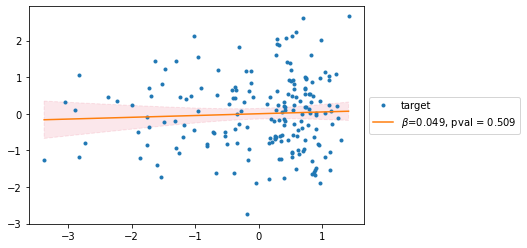

In [90]:
df = european_cortical_dataset_term
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
model, _ = data_exploration.mass_univariate(df = df,
                                           cont_independentVar_cols=ancestry,
                                           dependentVar_cols=['PRS_1e-08'])
corrected_PRS = model.resid
model, _ = data_exploration.mass_univariate(df = df,
                                           cat_independentVar_cols=['Gender'],
                                           cont_independentVar_cols=['Intracranial_Imperial','GA_vol','PMA_vol'],
                                           dependentVar_cols=['mean_CC'])
corrected_y = model.resid
visualisation.plot_Linear_Reg(y = corrected_y[abs(corrected_y)<3],
        x = corrected_PRS[abs(corrected_y)<3])

In [33]:
#examining high vs. low risk

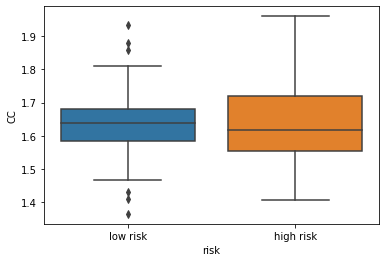

In [36]:
# corrected_CC = data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(european_cortical_dataset_term['mean_CC']),StandardScaler().fit_transform(european_cortical_dataset_term[['GA_vol','PMA_vol','Gender']]))

corrected_CC = np.asarray(european_cortical_dataset_term['mean_CC'])

high_risk, low_risk = data_preprocessing.high_low_risk_divide(data_preprocessing.adjusting_for_covariates_with_lin_reg(np.asarray(mixed_cortical_dataset_term['PRS_0.05']),StandardScaler().fit_transform(mixed_cortical_dataset_term[['mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3','mixed_Anc_PC4','mixed_Anc_PC5']])),low_perc=.3,high_perc=.3)

corrected_CC_df=pd.DataFrame({'CC':corrected_CC,'risk':['high risk' if i in high_risk else 'low risk' if i in low_risk else np.nan for i in range(len(corrected_CC))]}).dropna()

from scipy.stats import ttest_ind
ttest_ind(corrected_CC_df[corrected_CC_df['risk']=='low risk']['CC'],corrected_CC_df[corrected_CC_df['risk']=='high risk']['CC'],equal_var=True)


sns.boxplot(x='risk',y='CC',data=corrected_CC_df)